<a href="https://colab.research.google.com/github/AlbaCastillo/Movie-Recommendations-Model/blob/main/EDAyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos y Transformaciones Finales

In [2]:
# Datos
# Se extrae directamente desde un archivo en la carpeta de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Se cargan los datos a un dataframe
movies_final = pd.read_csv("/content/drive/MyDrive/Modelo de Recomendaciones (Movies)/movies_final.csv")
credits_final = pd.read_csv("/content/drive/MyDrive/Modelo de Recomendaciones (Movies)/credits_final.csv")

In [4]:
movies_final.head(1)

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,return,release_year,collection_name,genres_name,production_companies_names,production_country,spoken_languages_names
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,NaN,Toy Story,7.7,5415.0,12.451801,1995,Toy Story Collection,"Animation, Comedy, Family",Pixar Animation Studios,United States of America,English


In [5]:
credits_final.head(1)

,id,cast_name,director
0,862,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter


In [6]:
final = pd.merge(movies_final, credits_final, on='id', how='left')

In [7]:
final.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'return', 'release_year',
       'collection_name', 'genres_name', 'production_companies_names',
       'production_country', 'spoken_languages_names', 'cast_name',
       'director'],
      dtype='object')

In [8]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   budget                      45424 non-null  float64
 1   id                          45424 non-null  int64  
 2   original_language           45413 non-null  object 
 3   overview                    44483 non-null  object 
 4   popularity                  45424 non-null  float64
 5   release_date                45424 non-null  object 
 6   revenue                     45424 non-null  float64
 7   runtime                     45178 non-null  float64
 8   status                      45344 non-null  object 
 9   tagline                     20415 non-null  object 
 10  title                       45424 non-null  object 
 11  vote_average                45424 non-null  float64
 12  vote_count                  45424 non-null  float64
 13  return                      454

Se propone la creacion de dos modelos o un hibrido, de un Knn y un algoritmo de similitud por texto

# Algoritmo de similitud

### Transformacion y limpieza de datos

In [77]:
# Df para algoritmo de filtrado colaborativo
# Columnas ['overview', 'tagline', 'title',  'cast_name']
final_s = final[['overview', 'tagline', 'title', 'cast_name']]
final_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   overview   44483 non-null  object
 1   tagline    20415 non-null  object
 2   title      45424 non-null  object
 3   cast_name  43071 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [78]:
# Eliminación de filas con valores nulos en la columna 'overview' ya que es en la que mas nos enfocaremos
final_s = final_s.dropna(subset=['overview'])

In [79]:
# Creación de una nueva columna 'description' concatenando 'overview' y 'tagline'
final_s['description'] = final_s['title'] + ' ' + final_s['overview'] + ' ' + final_s['tagline'].fillna('')  + ' ' + final_s['cast_name'].fillna('')


In [12]:
final_s.head(2)

,overview,tagline,title,cast_name,description
0,"Led by Woody, Andy's toys live happily in his ...",NaN,Toy Story,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","Toy Story Led by Woody, Andy's toys live happi..."
1,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jumanji When siblings Judy and Peter discover ...


In [13]:
final_s.iloc[1,4]

"Jumanji When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. Roll the dice and unleash the excitement! Robin Williams, Jonathan Hyde, Kirsten Dunst, Bradley Pierce, Bonnie Hunt, Bebe Neuwirth, David Alan Grier, Patricia Clarkson, Adam Hann-Byrd, Laura Bell Bundy, James Handy, Gillian Barber, Brandon Obray, Cyrus Thiedeke, Gary Joseph Thorup, Leonard Zola, Lloyd Berry, Malcolm Stewart, Annabel Kershaw, Darryl Henriques, Robyn Driscoll, Peter Bryant, Sarah Gilson, Florica Vlad, June Lion, Brenda Lockmuller"

In [14]:
# Eliminamos las columnas ['overview', 'tagline',  'cast_name']
final_s = final_s.drop(['overview', 'tagline', 'cast_name'], axis=1)

In [15]:
final_s.columns

Index(['title', 'description'], dtype='object')

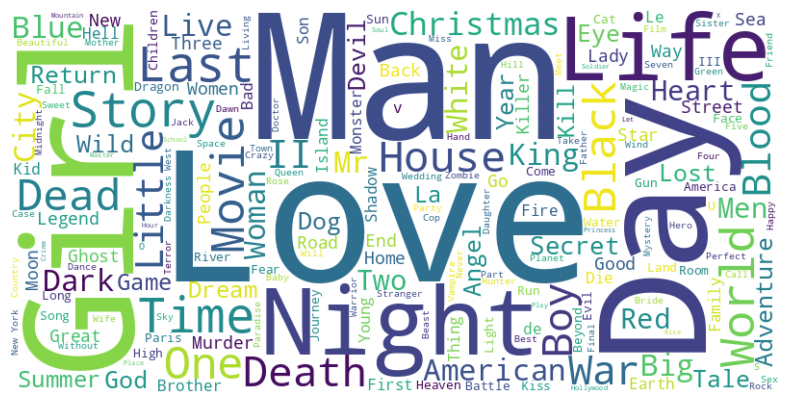

In [80]:
from wordcloud import WordCloud

titles = final_s['title']
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# Configuración de la columna 'title' como índice del DataFrame
final_s = final_s.set_index('title')

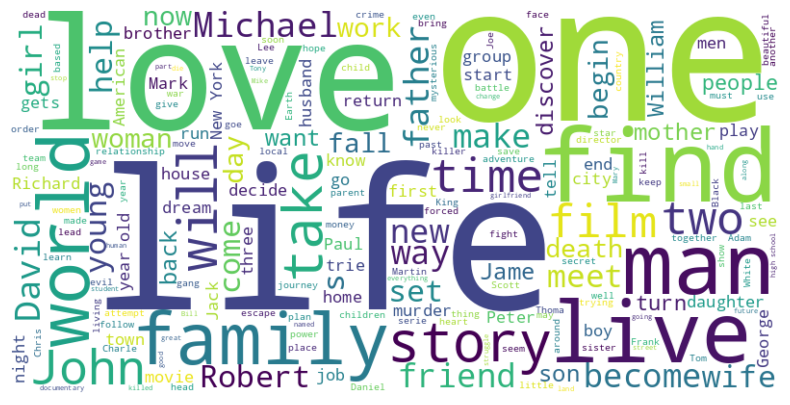

In [75]:
from wordcloud import WordCloud

titles = final_s['description']
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## ML (Modelo de similitud a travez del texto)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [71]:
# El df completo es mucho para procesar con los recursos disponibles
# Probamos con una porcion
final_s2 = final_s.sample(frac=0.5, random_state=1)
# Se probo con diferentes cantidades, y el 50% fue la mayor cantidad sin sobrepasar los limites de los recursos

In [66]:
# Creación de un vectorizador TF-IDF para la columna 'description'
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(final_s2['description'])

In [67]:
# Cálculo de las similitudes entre contenidos
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [68]:
def get_similar_movies(movie_title, top_n=5):
    idx = final_s2.index.get_loc(movie_title)
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_titles = [final_s2.index[i] for i in [i[0] for i in sim_scores]]
    return movie_titles

In [69]:
# Ejemplo de recomendación para la película "The Dark Knight"
recommended_movies = get_similar_movies("The Dark Knight", top_n=5)
print(recommended_movies)

['Batman: The Dark Knight Returns, Part 2', 'Chain Reaction', 'Batman Returns', 'Pearl Harbor', 'Batman Beyond: Return of the Joker']


In [70]:
# Ejemplo de recomendación para la película "Toy Story"
recommended_movies = get_similar_movies("Toy Story", top_n=5)
print(recommended_movies)

['Toy Story 2', 'Toy Story 3', 'Toy Story of Terror!', 'Partysaurus Rex', 'Hawaiian Vacation']


# KNN

In [73]:
# Columnas que se van a usar ['budget', 'original_language', 'popularity', 'revenue', 'runtime',
# 'title','vote_average', 'return', 'release_year', 'genres_name', 'spoken_languages_names', 'director']
final_knn = final [['budget', 'original_language', 'popularity', 'revenue', 'runtime', 'title','vote_average', 'return', 'release_year', 'genres_name', 'spoken_languages_names', 'director']]
final_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   budget                  45424 non-null  float64
 1   original_language       45413 non-null  object 
 2   popularity              45424 non-null  float64
 3   revenue                 45424 non-null  float64
 4   runtime                 45178 non-null  float64
 5   title                   45424 non-null  object 
 6   vote_average            45424 non-null  float64
 7   return                  45424 non-null  float64
 8   release_year            45424 non-null  int64  
 9   genres_name             43039 non-null  object 
 10  spoken_languages_names  41530 non-null  object 
 11  director                44588 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 4.5+ MB


### EDA (Exploratory Data Analysis)


## ML